In [13]:
from models import NetworkedRENs, REN, RNNModel, gain
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from os.path import dirname, join as pjoin
import torch
from torch import nn

dtype = torch.float
device = torch.device("cpu")

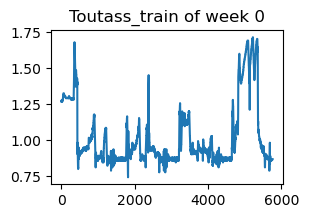

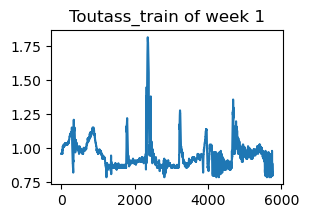

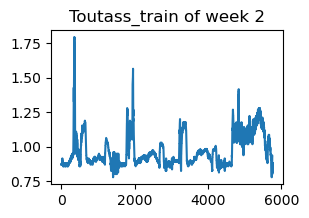

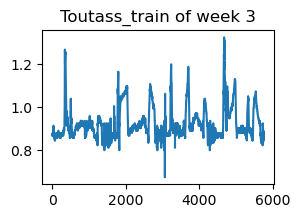

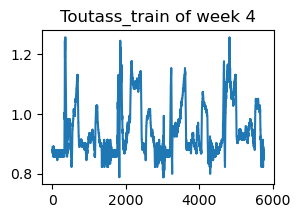

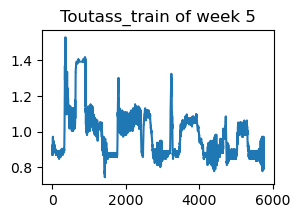

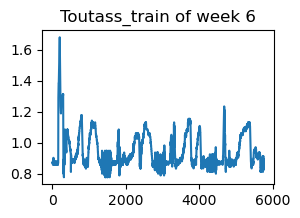

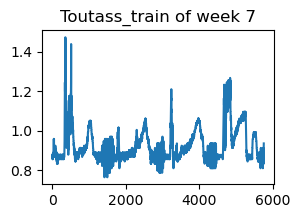

In [14]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt


# Load raw data
data = scipy.io.loadmat('raw_data.mat')

# Extract variables
Trit_GF = data['Trit_GF'].flatten()
Qhotd = data['Qhotdata'].flatten()
#statusAsst = data['statusAsstdata'].flatten()
IO_chillers = data['stato1'].flatten() + data['stato2'].flatten() + data['stato3'].flatten() + data['stato4'].flatten()
weektime = data['weektime'].flatten()
wendtime = data['wendtime'].flatten()
t = data['time'].flatten()
Text = data['Text'].flatten()
Hext = data['Hext'].flatten()
Tman_GF = data['Tman_GF'].flatten()
Toutass = data['Toutass'].flatten()
Toutchill = (data['Toutrefr1'].flatten() + data['Toutrefr2'].flatten() + data['Toutrefr3'].flatten() + data['Toutrefr4'].flatten())/4
Qu = data['buildtot'].flatten()


# Example of adjustments in Python
# Combine week and weekend times
WEEK = weektime + wendtime / 2

# Combine status variables
Status_global = data['stato1'] + data['stato2'] + data['stato3'] + data['stato4']

# Normalize data function
def normalize(data):
    mean = np.mean(data)
    data_norm = data / mean
    return mean, data_norm

# Normalize selected variables
Trit_mean, Trit_GF = normalize(Trit_GF)
Qhotd_mean, Qhotd = normalize(Qhotd)
IO_mean, IO_chillers = normalize(IO_chillers)
Tman_mean, Tman_GF = normalize(Tman_GF)
Toutass_mean, Toutass = normalize(Toutass)
Toutchill_mean, Toutchill = normalize(Toutchill)
Qu_mean, Qu = normalize(Qu)

# Adjust training data
one_week = 231840 - 221760
nb_weeks = 1  # Change as required
start = 6 * one_week
end_train = 10 * one_week
nExp = 4
t_end = 4*1440 # 4days (2 to 5)
one_day = 1440

#init the variables for outputs and inputs/disturbances
Toutchill_t = np.zeros((nExp*2, t_end))
Toutass_t = np.zeros((nExp*2, t_end))
Trit_t = np.zeros((nExp*2, t_end))
Q_users_t = np.zeros((nExp*2, t_end))
Q_abs_t = np.zeros((nExp*2, t_end))
IO_chillers_t = np.zeros((nExp*2, t_end))
Tman_t = np.zeros((nExp*2, t_end))

Toutchill_v = np.zeros((1, t_end))
Toutass_v = np.zeros((1, t_end))
Trit_v = np.zeros((1, t_end))
Q_users_v = np.zeros((1, t_end))
Q_abs_v = np.zeros((1, t_end))
IO_chillers_v = np.zeros((1, t_end))
Tman_v = np.zeros((1, t_end))

for exp in range(nExp):
    Toutchill_t[exp,:] = Toutchill[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Toutass_t[exp,:] = Toutass[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Trit_t[exp,:] = Trit_GF[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Q_users_t[exp,:] = Qu[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Q_abs_t[exp,:] = Qhotd[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    IO_chillers_t[exp,:] = IO_chillers[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Tman_t[exp,:] = Tman_GF[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]

    # Plotting
    plt.figure(figsize=(3, 2))
    plt.plot(Toutass_t[exp,:])
    plt.title(f'Toutass_train of week {exp}')
    plt.show()
    
Toutchill_v[0,:] = Toutchill[start + nExp*one_week + 1* one_day:start  + nExp*one_week + 1* one_day + t_end]
Toutass_v[0,:] = Toutass[start + nExp*one_week + 1* one_day:start  + nExp*one_week + 1* one_day + t_end]
Trit_v[0,:] = Trit_GF[ start + nExp*one_week + 1* one_day:start  + nExp*one_week + 1* one_day + t_end]
Q_users_v[0,:] = Qu[start + nExp*one_week + 1* one_day:start  + nExp*one_week + 1* one_day + t_end]
Q_abs_v[0,:] = Qhotd[start + nExp*one_week + 1* one_day:start  + nExp*one_week + 1* one_day + t_end]
IO_chillers_v[0,:] = IO_chillers[start + nExp*one_week + 1* one_day:start  + nExp*one_week + 1* one_day + t_end]
Tman_v[0,:] = Tman_GF[start + nExp*one_week + 1* one_day:start  + nExp*one_week + 1* one_day + t_end]

for exp in range(nExp, nExp*2):
    Toutchill_t[exp,:] = Toutchill[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Toutass_t[exp,:] = Toutass[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Trit_t[exp,:] = Trit_GF[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Q_users_t[exp,:] = Qu[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Q_abs_t[exp,:] = Qhotd[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    IO_chillers_t[exp,:] = IO_chillers[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]
    Tman_t[exp,:] = Tman_GF[start + exp*one_week + 1* one_day:start  + exp*one_week + 1* one_day + t_end]

    # Plotting
    plt.figure(figsize=(3, 2))
    plt.plot(Toutass_t[exp,:])
    plt.title(f'Toutass_train of week {exp}')
    plt.show()



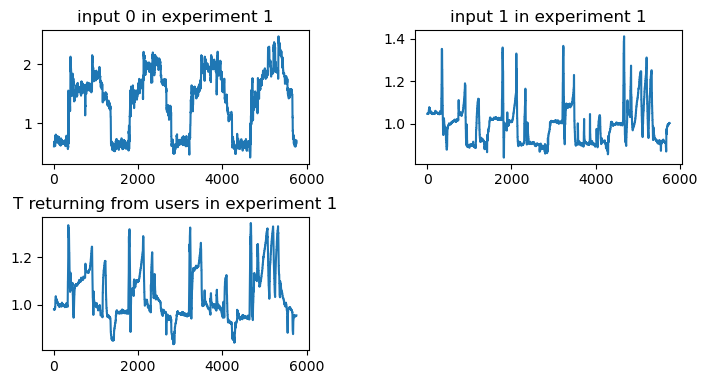

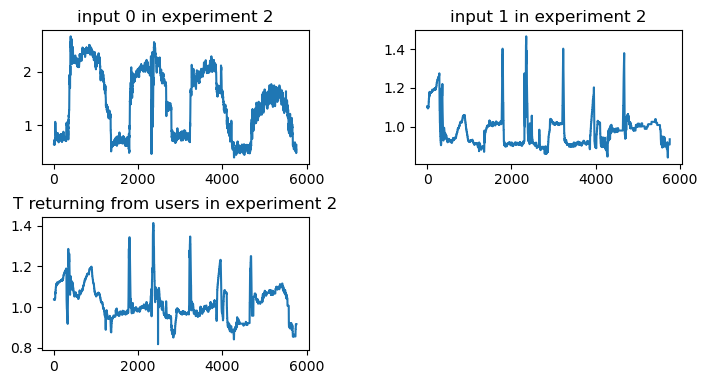

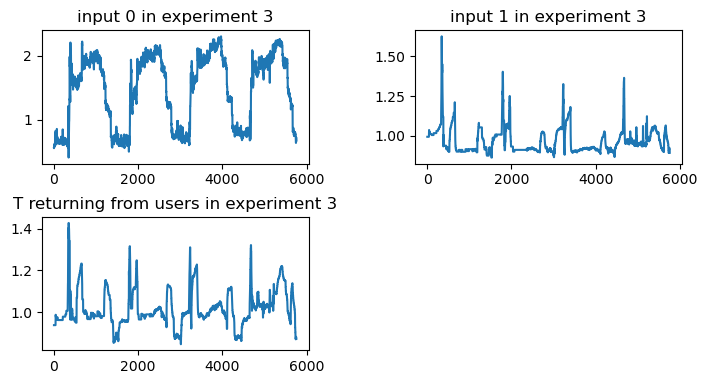

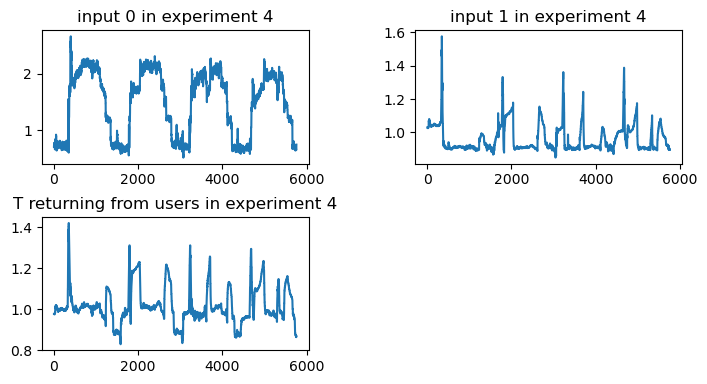

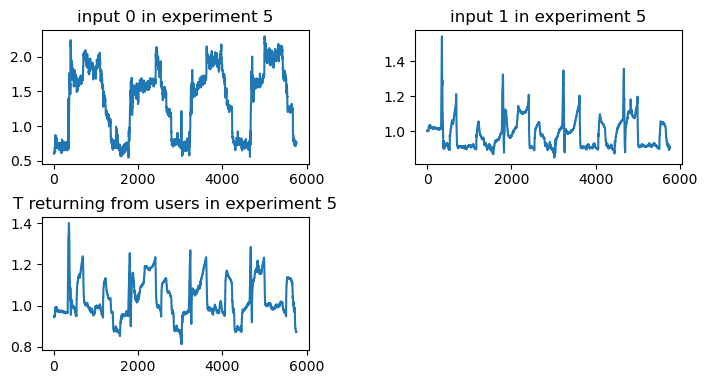

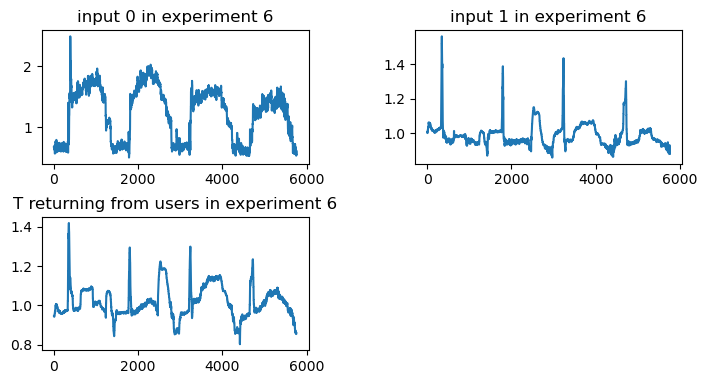

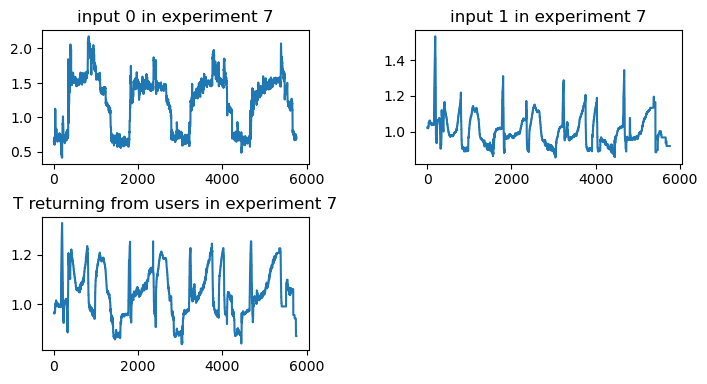

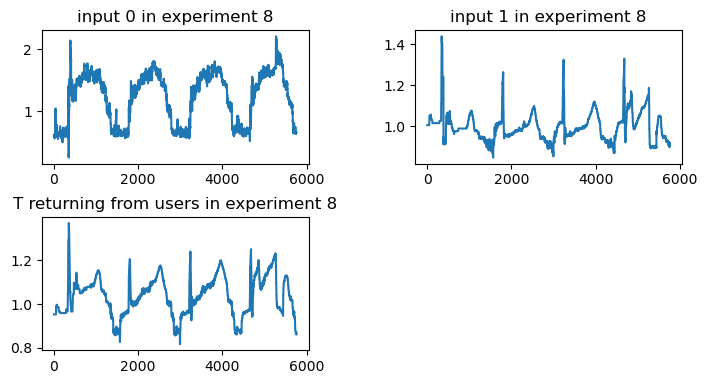

In [15]:
#initialize the model
ny = 1
nd = 2

for exp in range(nExp*2):
    y_exp = torch.from_numpy(Trit_t[exp,:]).float().to(device)
    d_exp = torch.cat((torch.from_numpy(Q_users_t[exp,:]).unsqueeze(1), torch.from_numpy(Tman_t[exp,:]).unsqueeze(1)), 1) 
    # Plotting
    plt.figure(figsize=(4 * 2, 4))
    for out in range(nd):
        plt.subplot(2, 2, out+1)
        plt.plot(d_exp[:, out])
        plt.title(r"input %i" %out + r" in experiment %i"%(exp+1))
    plt.subplot(2, 2, nd+1)
    plt.plot(y_exp)
    plt.title(r"T returning from users in experiment %i"%(exp+1))
    
    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
plt.show()

Epoch: 1 	||	 Loss: 5.681159973144531
L2 gain REN: 1


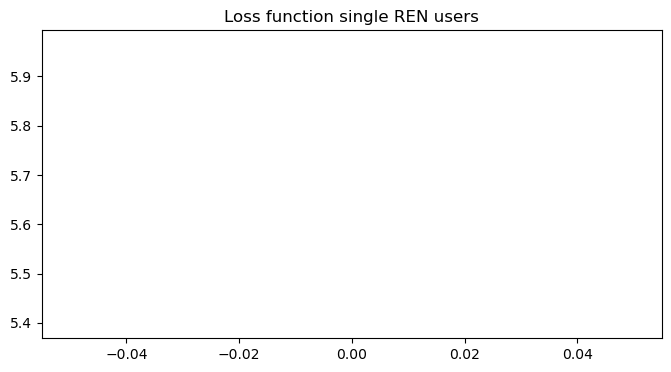

In [ ]:
# Train single REN USERS
"""
epochs = 350

n = 2# input dimensions
p = 1  # output dimensions
n_xi = 7# nel paper n1, numero di stati
l = 7  # nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the RE

# Define the model
RENsys = REN(n, p, n_xi, l, gammaTrain = False, gamma=1)
# Define Loss function
MSE = nn.MSELoss()
# Define Optimization method
learning_rate = 1.0e-3
optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
optimizer.zero_grad()
#init loss
LOSS = np.zeros(epochs)

for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-2
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0
    
    for exp in range(2*nExp):
        y = torch.from_numpy(Trit_t[exp,:]).float().to(device).unsqueeze(1) #T_returning_users
        y = y.T
        yRENm = torch.randn(p, t_end, device=device, dtype=dtype)
        yRENm[:,0] = y[:,0]
        xi = torch.randn(n_xi)
        d = torch.cat((torch.from_numpy(Q_users_t[exp,:]).float().unsqueeze(1), torch.from_numpy(Tman_t[exp,:]).float().unsqueeze(1)), 1) # Q_users and T_man             
        d = d.T
        for t in range(1, t_end):
            yRENm[:, t], xi = RENsys(d[:, t - 1], xi, t)
        loss = loss + MSE(yRENm[:, 0:yRENm.size(1)], y[:, 0:t_end + 1])
        # ignore condition initial loss

    loss = loss / 2/nExp
    
    loss.backward(retain_graph=True)
    

    optimizer.step()
    RENsys.set_param()

    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    print(f"L2 gain REN: {RENsys.gamma}")
    LOSS[epoch] = loss
    
    # save a checkpoint every 20 epochs
    if epoch % 20 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': RENsys.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, f'users_epoch_{epoch+1}.pth')

plt.figure(figsize=(4 * 2, 4))
plt.plot(LOSS)
plt.title("Loss function single REN users")
plt.show()
"""

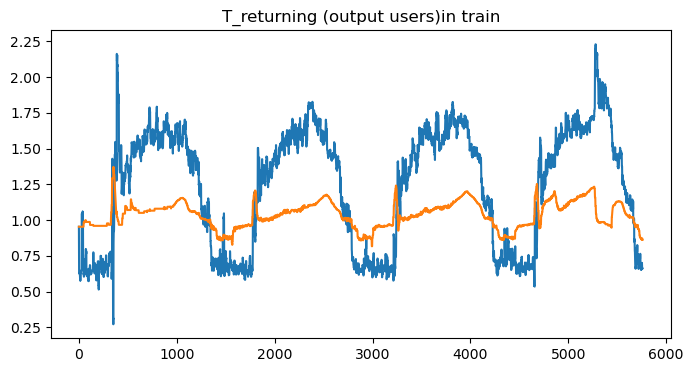

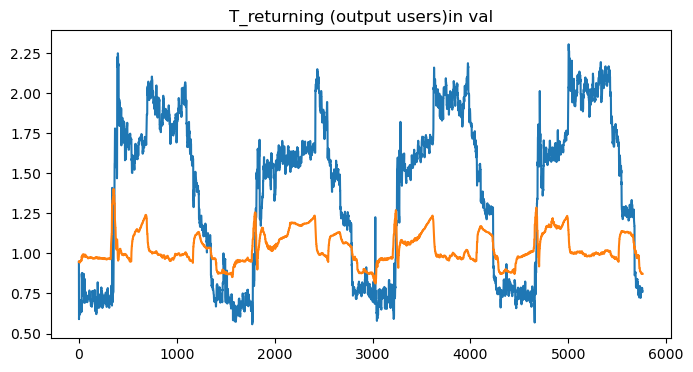

Loss Validation single REN users: 0.34431952238082886


In [ ]:
# validation single REN users
"""
yval = torch.from_numpy(Trit_v[0,:]).float().to(device).unsqueeze(1) #T_rit
yval = yval.T
yRENm_val = torch.zeros(p, t_end, device=device, dtype=dtype)
yRENm_val[:,0] = yval[:,0]
xiVal = torch.randn(n_xi)
dval = torch.cat((torch.from_numpy(Q_users_v[0,:]).float().unsqueeze(1), torch.from_numpy(Tman_v[0,:]).float().unsqueeze(1)), 1) # Q_users and T_man        
dval = dval.T
loss_val = 0
for t in range(1, t_end):
    yRENm_val[:, t], xiVal = RENsys(dval[:, t - 1], xiVal, t)
loss_val = loss_val + MSE(yRENm_val[:, 0:yRENm_val.size(1)], yval[:, 0:t_end + 1])

loss_val_REN_users = loss_val

plt.figure(figsize=(4 * 2, 4))
for out in range(p):
    plt.subplot(1, p, out+1)
    plt.plot(Trit_mean*yRENm[out, 0:t_end].detach().numpy(), label='REN train users')
    plt.plot(Trit_mean*y[out, 0:t_end].detach().numpy(), label='y train users')
    plt.title(r"T_returning (output users)" + r"in train")  
plt.show()

plt.figure(figsize=(4 * 2, 4))
for out in range(p):
    plt.subplot(1, p, out+1)
    plt.plot(Trit_mean*yRENm_val[out, 0:t_end].detach().numpy(), label='REN val users')
    plt.plot(Trit_mean*yval[out, 0:t_end].detach().numpy(), label='y val')
    plt.title(r"T_returning (output users)" + r"in val")  
plt.show()

pytorch_total_params_singleREN = sum(p.numel() for p in RENsys.parameters() if p.requires_grad)
print(f"Loss Validation single REN users: {loss_val_REN_users}")
"""

In [ ]:
# Train single REN ABSORBER adding two days per exp 
"""
epochs = 350

n = 2  # input dimensions
p = 1  # output dimensions
n_xi = 5# nel paper n1, numero di stati
l = 5# nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the REN

# Define the model
RENsys = REN(n, p, n_xi, l, gammaTrain = False, gamma= 1)
# Define Loss function
MSE = nn.MSELoss()
# Define Optimization method
learning_rate = 1.0e-1
optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
optimizer.zero_grad()

LOSS = np.zeros(epochs)

for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-2
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0
    for exp in range(nExp):
        # one week = 10080
        # one day = 1440
        # take data of every week between 2 and 5
        y = torch.from_numpy(Toutass_t[exp, :]).float().to(device) #Toutass
        y = y.T
        yRENm = torch.randn(p, t_end, device=device, dtype=dtype)
        yRENm[:,0] = y[:,0]
        xi = torch.randn(n_xi)

        d = torch.cat(( torch.from_numpy(Trit_t[exp,:]).float().to(device).unsqueeze(1),#T_rit
                        torch.from_numpy(Q_abs_t[exp,:]).float().to(device).unsqueeze(1)), dim=1) #Q_abs             
        d = d.T
        for t in range(1, t_end):
            yRENm[:, t], xi = RENsys(d[:,t-1], xi, t)
        loss = loss + MSE(yRENm[:, 0:yRENm.size(1)], y[:, 0:t_end + 1])

    loss = loss /2/nExp
    #loss.backward()
    loss.backward(retain_graph=True)

    optimizer.step()
    RENsys.set_param()

    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    print(f"L2 gain REN: {RENsys.gamma}")
    LOSS[epoch] = loss
    
    # save a checkpoint every 20 epochs
    if epoch % 20 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': RENsys.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, f'abs_epoch_{epoch+1}.pth')

plt.figure(figsize=(4 * 2, 4))
plt.plot(LOSS)
plt.title("Loss function single REN absorber")
plt.show()
"""

In [33]:
# TRAIN OF NETWORKED RENs
epochs = 2

torch.manual_seed(2)
N = 3 # Number of interconnected systems

n = torch.tensor([2, 2, 2])  # input dimensions
p = torch.tensor([1, 1, 1])  # output dimensions

n_xi = np.array([10, 5, 5]) # nel paper n1, numero di stati
l = np.array([10, 5, 5])  # nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the RE

alpha = 0.5
beta = 0.5

Muy = torch.cat((torch.tensor([[0, alpha, beta], [1, 0, 0], [1, 0, 0]]), torch.zeros(3,3)), dim=0)
Muy = Muy.float()

Mud = torch.cat((torch.zeros(3,3), torch.eye(3)), dim=0)
Mey = torch.tensor([[0, alpha, beta], [1, 0, 0]])

# Define the system
RENsys = NetworkedRENs(N, Muy, Mud, Mey, n, p, n_xi, l)

# Define Loss function
MSE = nn.MSELoss()

# load subsytems 
checkpoint = [None] * N  # A list with N elements
checkpoint[0] = torch.load('checkpoint_users_epoch_200.pth')
checkpoint[1] = torch.load('checkpoint_2moredays_absorber_epoch_200.pth')
checkpoint[2] = torch.load('checkpoint_moreexp_chillers_epoch_250.pth')

# Initialize REN modules and load states
mods = [REN(RENsys.m[j], RENsys.p[j], RENsys.n[j], RENsys.l[j]) for j in range(N)]
for j in range(N):
    mods[j].load_state_dict(checkpoint[j]['model_state_dict'])

# update RENsys.r
RENsys.r = nn.ModuleList(mods)

# necessary ?
state_dict = RENsys.state_dict()  

# Define Optimization method
learning_rate = 1.0e-1
optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
optimizer.zero_grad()

LOSS = np.zeros(epochs)
loss = 0

for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-2
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0
    for exp in range(2*nExp):
        T_man_for_loss = torch.from_numpy(Tman_t[exp,:]).float().to(device).unsqueeze(1)
        xi = []
        y = torch.cat((torch.from_numpy(Trit_t[exp,:]).float().to(device).unsqueeze(1),
                       torch.from_numpy(Toutass_t[exp,:]).float().to(device).unsqueeze(1),
                       torch.from_numpy(Toutchill_t[exp,:]).float().to(device).unsqueeze(1)), dim=1)
        y = y.T
        yRENm = torch.randn(3,t_end , device=device, dtype=dtype)
        yRENm[0,:] = y[0,:]
        for j in range(N):
            xi.append(torch.randn(RENsys.r[j].n, device=device, dtype=dtype))
        d = torch.cat((torch.from_numpy(Q_users_t[exp,:]).float().to(device).unsqueeze(1),
                       torch.from_numpy(Q_abs_t[exp,:]).float().to(device).unsqueeze(1),
                       torch.from_numpy(IO_chillers_t[exp,:]).float().to(device).unsqueeze(1)), dim=1)
        d = d.T
        xi = torch.cat(xi)
        for t in range(1, t_end):
            yRENm[:, t], xi = RENsys(t, d[:, t - 1], xi)

        loss = loss + MSE(yRENm[:, 0:yRENm.size(1)], y[:, 0:t_end + 1])  + MSE(T_man_for_loss.T, (RENsys.Muy[0,1:3].unsqueeze(0) @ yRENm[1:, 0:t_end + 1]))

    loss = loss / 2/nExp
    loss.backward()
    # loss.backward(retain_graph=True)

    optimizer.step()

    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    for net in range(N):
        print(f"L2 gain REN%i"%net+":%.1f"%RENsys.r[net].gamma)
    LOSS[epoch] = loss
    
    # save a checkpoint every 20 epochs
    if epoch % 20 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': RENsys.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, f'network_epoch_{epoch+1}.pth')

C:\Users\adela\AppData\Local\Temp\ipykernel_16088\3457731381.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint[0] = torch.load('checkpoint_users_epoch_200.pth'

torch.Size([1, 2])
torch.Size([2, 5760])
tensor([[ 0.0700,  0.1599,  0.3093,  ..., -0.9961, -1.0099, -0.9734]],
       grad_fn=<MmBackward0>)
torch.Size([5760, 1])
torch.Size([1, 2])
torch.Size([2, 5760])
tensor([[-0.1254, -1.2610, -1.0034,  ..., -0.9953, -0.9159, -0.8204]],
       grad_fn=<MmBackward0>)
torch.Size([5760, 1])
torch.Size([1, 2])
torch.Size([2, 5760])
tensor([[-0.8401, -0.9745, -0.8885,  ..., -0.3513, -0.2224, -0.0539]],
       grad_fn=<MmBackward0>)
torch.Size([5760, 1])
torch.Size([1, 2])
torch.Size([2, 5760])
tensor([[-0.2414, -1.1261, -1.1037,  ..., -0.5218, -0.4566, -0.4110]],
       grad_fn=<MmBackward0>)
torch.Size([5760, 1])


KeyboardInterrupt: 